In [447]:
import nltk
nltk.download('wordnet')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from sklearn.multiclass import OneVsRestClassifier
from joblib import dump, load

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/artyomkholodkov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [401]:
data = pd.read_csv('/Users/artyomkholodkov/Downloads/raw_text.csv')

In [402]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    860 non-null    object
 1   label   860 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [403]:
data

,text,label
0,The following content is\nprovided under a Cre...,Calculus
1,"In this sequence of segments,\nwe review some ...",Probability
2,The following content is\nprovided under a Cre...,CS
3,The following\ncontent is provided under a Cre...,Algorithms
4,The following\ncontent is provided under a Cre...,Algorithms
...,...,...
855,The following content is\nprovided under a Cre...,Math for Eng.
856,&gt;&gt; [MUSIC] &gt;&gt; DAVID J. MALAN: All ...,Diff. Eq.
857,The following content is\nprovided by MIT Open...,Linear Algebra
858,The following content is\nprovided under a Cre...,AI


Посмотрим на уникальные значения label

In [404]:
unique_labels = np.unique(data['label'].values)
unique_labels

array(['AI', 'Algorithms', 'CS', 'Calculus', 'Data Structures',
       'Diff. Eq.', 'Linear Algebra', 'Math for Eng.', 'NLP',
       'Probability', 'Statistics'], dtype=object)

Визуализируем распределение целевого признака

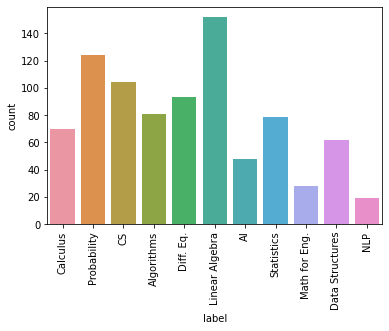

In [405]:
plt.figure()
sns.countplot(x='label', data=data)
plt.xticks(rotation=90)
plt.show()

Отчистим и лемматизируем текст, понизив тем самым размерность признакового пространства

In [406]:
tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

In [407]:
def clean_data(data):
    cleaned_sent = []
    for sent in data:
        sent = sent.lower() #lower string
        sent = re.sub(r'\d+', '', sent) #remove numbers
        sent = ' '.join([word for word in sent.split() if word not in stopwords.words('english')]) #remove stop words
        sent = ' '.join(tokenizer.tokenize(sent)) #tokenize
        sent = re.sub(r'[^\w\s]','',sent) #remove punctuation
        sent = ' '.join([lemmatizer.lemmatize(word) for word in sent.split()]) #lemmatize words
        cleaned_sent.append(sent)
    return cleaned_sent

Отчистим текст

In [408]:
text = clean_data(data['text'].values)

In [409]:
data['cleaned_text'] = text

Подготвим значения целевого признака

In [410]:
def prep_targets(name):
    if name == 'Calculus':
        return 0
    elif name == 'Probability':
        return 1
    elif name == 'CS':
        return 2
    elif name == 'Algorithms':
        return 3
    elif name == 'Diff. Eq.':
        return 4
    elif name == 'Linear Algebra':
        return 5
    elif name == 'AI':
        return 6
    elif name == 'Statistics':
        return 7
    elif name == 'Math for Eng.':
        return 8
    elif name == 'Data Structures':
        return 9
    else:
        return 10

In [411]:
data['targets'] = data['label'].apply(lambda x: prep_targets(x))

Слегка выровняем распределение значений целевого признака, применив positive sampling (чтобы позволить алгоритму настраиваться на все классы)

In [412]:
multipliers = {'AI': 0.5, 'Math for Eng.': 2, 'Data Structures': 0.3, 'NLP': 3}

In [413]:
data_ext = data

for label, multiplier in multipliers.items():
    data_size = data[data['label'] == label].shape[0]
    index = data[data['label'] == label].index
    
    size_to_add = int(multiplier * data_size)
    index = np.random.choice(index, size_to_add)
    data_ext = pd.concat([data_ext, data.loc[index, :]])

In [414]:
data_ext.shape

(1015, 4)

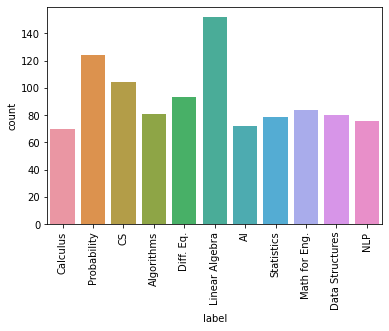

In [415]:
plt.figure()
sns.countplot(x='label', data=data_ext)
plt.xticks(rotation=90)
plt.show()

Подготовим numpy массивы для текста и значений целевой переменной

In [457]:
features = data_ext['cleaned_text'].values
targets = data_ext['targets'].values

Разделим выборку на тренировочный и тестовый набор. На практике, выборку делят на тренировочную, валидационную и тестовую. Валидационную используют для проверки качества модели, а тестовую - после окончательного выбора модели (например перед запуском в продакшн). Мы же просто разделим на тренировочную и тестовую из-за ограниченного размера выборки

In [458]:
data_train, data_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.1)

Класс для Pipeline для трансформации матрицы объекты признаки в sparse формат (нужен для PCA)

In [459]:
from sklearn.base import BaseEstimator, TransformerMixin

class ToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return csr_matrix(X).todense()

Logistic regression - строго бинарный классификатор, поэтому импользуемая стратегия тренировки в случае мультиклассовости - OVO. Но лучше использовать OVR из-за ограниченного размера выборки.

In [460]:
classifier = OneVsRestClassifier(Pipeline([
('vectorizer', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 3), min_df=0.05, max_df=0.5)),
('denser', ToDenseTransformer()),
('reductor', PCA(n_components=0.95)),
('classifier', LogisticRegression(penalty='l2', n_jobs=-1))]))

Проверим качество по кросс-валидации. Стратификация производится по умолчанию

In [446]:
cross_val_score(classifier, data_train, targets_train, scoring='accuracy', cv=3)

array([0.2557377 , 0.19736842, 0.17434211])

Построим confusion matrix при помощи cross_val_predict

In [425]:
classifier.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [426]:
y_pred = cross_val_predict(classifier, data_train, targets_train, cv=3)
conf_mx = confusion_matrix(targets_train, y_pred)
conf_mx

array([[ 1,  7,  7,  0,  5, 32,  1,  0,  2,  2,  3],
       [ 0, 24, 10,  3,  8, 51,  3,  1,  3,  3,  5],
       [ 0, 22,  7,  3,  3, 45,  0,  0,  6,  2,  4],
       [ 0,  9,  4,  2,  1, 42,  1,  2,  6,  3,  3],
       [ 0, 18,  6,  3,  5, 42,  1,  0,  4,  2,  8],
       [ 2, 24,  6,  5,  7, 71,  2,  2,  7,  5,  7],
       [ 0, 13,  6,  3,  0, 29,  6,  0,  2,  1,  2],
       [ 1, 10,  9,  0,  4, 34,  0,  1,  4,  2,  2],
       [ 0, 10,  4,  0,  0, 22,  0,  0, 39,  0,  2],
       [ 0, 16,  5,  4,  3, 29,  0,  1,  6,  6,  2],
       [ 0, 10,  1,  0,  0, 14,  0,  0,  2,  0, 45]])

<Figure size 432x288 with 0 Axes>

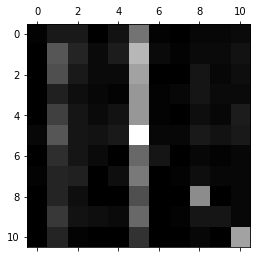

In [430]:
plt.figure()
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Посмотрим на частоты ошибок по классам

In [432]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

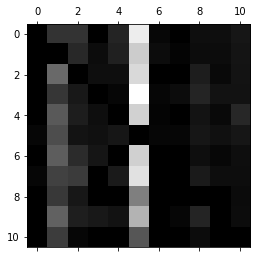

In [433]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Можно сделать вывод о том, что алгоритм успел настроиться на 5-й класс, и ошибочно принимает другие классы за 5-й. Это может быть сзязано с наибольшей долей объектов пятого класса. То же самое относится ко 2-му классу (Probability), но в меньшей степени. Также, алгоритм правильо предсказывает Math for Eng. и NLP. Это может быть связано с применением positive sampling и тем фактом, что объекты данных классов могут иметь одинаковое признаковое описание в валидационном фолде на кросс-валидации. Настроим алгоритм на всем тренировочном наборе и проверим качество на test_set:

In [461]:
classifier.fit(data_train, targets_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('vectorizer',
                                               TfidfVectorizer(analyzer='char_wb',
                                                               max_df=0.5,
                                                               min_df=0.05,
                                                               ngram_range=(2,
                                                                            3))),
                                              ('denser', ToDenseTransformer()),
                                              ('reductor',
                                               PCA(n_components=0.95)),
                                              ('classifier',
                                               LogisticRegression(n_jobs=-1))]))

In [462]:
predictions = classifier.predict(data_test)

In [463]:
accuracy_score(targets_test, predictions)

0.21568627450980393

In [464]:
dump(classifier, '/Users/artyomkholodkov/Downloads/Models/model.pkl', compress=1) 

['/Users/artyomkholodkov/Downloads/Models/model.pkl']

In [465]:
classifier.predict(data_ext['cleaned_text'][:10].values)

array([1, 1, 5, 3, 3, 5, 3, 5, 2, 5])

Видим, что при отсутствии стратификации на тестовом наборе, классификатор показывает качество еще хуже. Уже по полученным результатам понятно, что классификатор достигает плохого качества из-за крайне ограниченного размера выборки. Даже после понижения размерности при помощи PCA, размерность матрицы объекты-признаки превышает 200. Учитывая, что при росте размерности признакового пространства необходимое количество объектов растет экспоненциально, 860 объектов в выборке крайне недостаточно для полученя классификатора с хорошим качеством, тем более учитывая мультиклассовость. Использование других алгоритмов, таких как XGBoost, SVM или Naive Bayes, также лишено особого смысла. Потенциальным выходом из ситуации является сбор большего количества данных.